# Method for selection of hyperparameters of parametrization

In [11]:
import numpy as np
import pickle
from spline_inter1d import SplineInter1D, _Spline
import matplotlib.pyplot as plt
from matplotlib2tikz import save as tikz_save
%matplotlib inline
from kde import KDE
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
import os
from matplotlib import animation, rc
from IPython.display import HTML
overwrite = True

In [12]:
tikz_path = os.path.join('..', '20171126 Parametrization', 'figures')
def tikz(name, extras=None):
    # Convert to tikz
    tikz_save(os.path.join(tikz_path, '{:s}.tikz'.format(name)),
              figureheight='\\figureheight', figurewidth='\\figurewidth',
              extra_axis_parameters=extras) 

## Simplified example

In [13]:
# Define the spline function that we later need
spl_event = SplineInter1D([0, 1], d=2, left_constraints=[1], right_constraints=[0])
spl = _Spline(spl_event.t, spl_event.d, spl_event.thetafixed)
def theta(thetatilde):
    return spl_event.thetafixed + np.dot(spl_event.v2, thetatilde)
def thetatilde(theta):
    return np.dot(spl_event.v2.T, theta - spl_event.thetafixed)

In [14]:
# This is the error function that measures how good the parameters 'z' fit with the curve y
def error(y, z, sigma=0.1):
    """Determine the error
    y is an test curve, evaluated at default x values
    z is a vector containing the parameters from the kde
    sigma 'Standard deviation', kind of allowed error
    """
    # Construct spline and evaluate
    spl.theta = theta(z)
    yz = spl()
    
    # Return the function
    # return np.mean(np.exp(-(y - yz)**2 / (2 * sigma**2))) / (sigma * np.sqrt(2*np.pi))
    # return np.mean(-np.abs(y - yz) / sigma) - np.log(2 * sigma)
    return np.exp(-np.log(2*np.pi)/2 - np.log(sigma) - np.mean((y - yz)**2) / (2 * sigma * sigma))
    # return np.exp(-np.mean(np.abs(y - yz) / sigma))

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


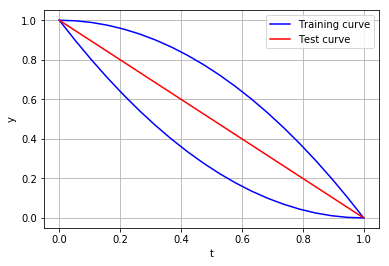

In [15]:
# Do it for a very simple case
t = np.linspace(0, 1, 20)
spl(t)  # Sets the x-values
v1 = -t**2 + 1
v2 = t**2 -2*t + 1
v3 = -t + 1
coef_train = np.array([thetatilde(spl_event.fit(t, v1).theta), thetatilde(spl_event.fit(t, v2).theta)])
plt.plot(t, v1, 'b', label='Training curve')
plt.plot(t, v2, 'b')
plt.plot(t, v3, 'r', label='Test curve')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.grid('on')
tikz('simple_case_overview') 

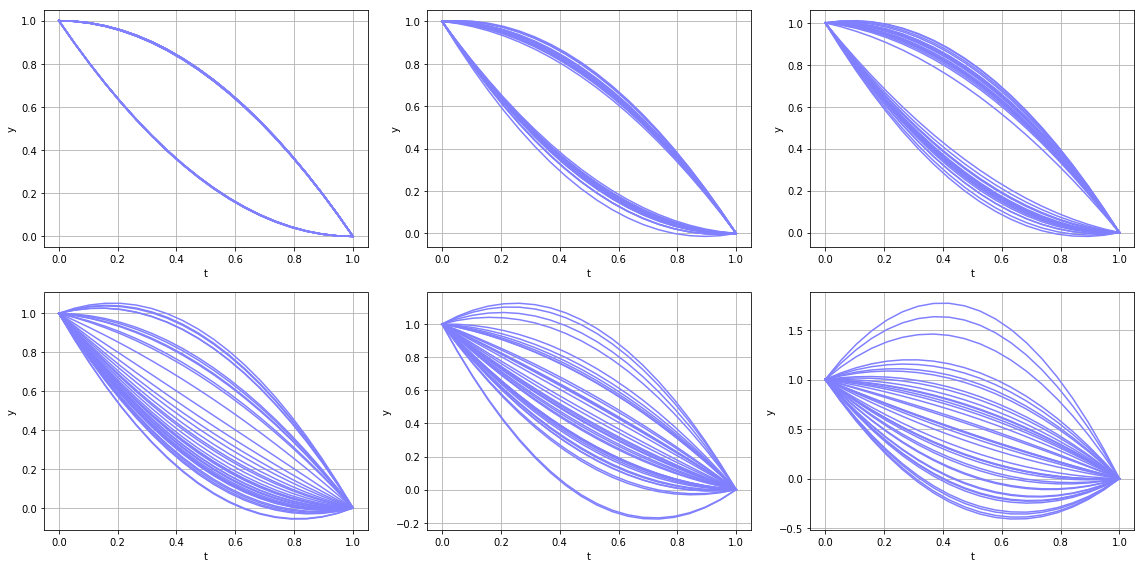

In [16]:
H = [0.01, 0.1, 0.2, 0.5, 1, 2]
f, axs = plt.subplots(2, 3, figsize=(16, 8))
for h, ax in zip(H, np.ravel(axs)):
    kde = KDE(coef_train, bandwidth=h, scale_data=False)
    kde.compute_kde()
    for i in range(40):
        z = kde.draw_random_sample(1)[0]
        spl.theta = theta(z)
        ax.plot(t, spl(t), color=[.5, .5, 1])
    #ax.set_title('h = {:.2f}'.format(h))
    ax.set_xlabel('t')
    ax.set_ylabel('y')
    ax.grid('on')
plt.tight_layout()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick

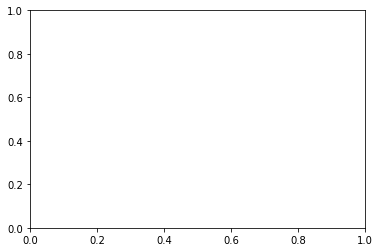

In [17]:
for j, h in enumerate(H):
    kde = KDE(coef_train, bandwidth=h, scale_data=False)
    kde.compute_kde()
    for i in range(40):
        z = kde.draw_random_sample(1)[0]
        spl.theta = theta(z)
        plt.plot(t, spl(t), color=[.5, .5, 1])
    plt.xlabel('t')
    plt.ylabel('y')
    plt.grid('on')
    tikz('simple_case_test_h{:d}'.format(j+1))
    plt.cla()

In [18]:
savefile = os.path.join('pickles', 'artificial_example.p')
N = 10000
H = np.logspace(-2, 1, 61)
Sigma = [0.005, 0.01, 0.05, 0.1, 0.5, 1]

E = np.zeros((len(Sigma), len(H)))
if overwrite or not os.path.exists(savefile):
    for isigma, sigma in enumerate(tqdm(Sigma)):
        for ih, h in enumerate(tqdm(H, leave=False)):
            kde = KDE(coef_train, bandwidth=h, scale_data=False)
            kde.compute_kde()
            e = np.zeros(N)
            for i in range(N):
                z = kde.draw_random_sample(1)[0]
                e[i] = error(v3, z, sigma=sigma)
            E[isigma, ih] = np.mean(e, axis=0)
    if not os.path.exists(os.path.dirname(savefile)):
        os.mkdir(os.path.dirname(savefile))
    with open(savefile, 'wb') as f:
        pickle.dump(E, f)
else:
    with open(savefile, 'rb') as f:
        E = pickle.load(f)

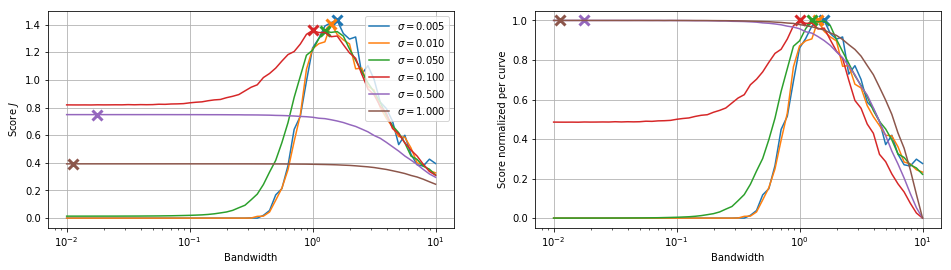

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
for sigma, e in zip(Sigma, E):
    plthandle = ax1.semilogx(H, e, label='$\sigma = {:.3f}$'.format(sigma))
    ax1.plot(H[np.argmax(e)], np.max(e), 'x', color=plthandle[0].get_color(), ms=10, mew=3)
    plthandle = ax2.semilogx(H, (e - np.min(e)) / (np.max(e) - np.min(e)), label='sigma = {:.3f}'.format(sigma))
    ax2.plot(H[np.argmax(e)], 1, 'x', color=plthandle[0].get_color(), ms=10, mew=3)
ax1.grid('on')
ax1.set_xlabel('Bandwidth')
ax1.set_ylabel('Score')
ax2.grid('on')
ax2.set_xlabel('Bandwidth')
ax2.set_ylabel('Score normalized per curve')
ax1.legend()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


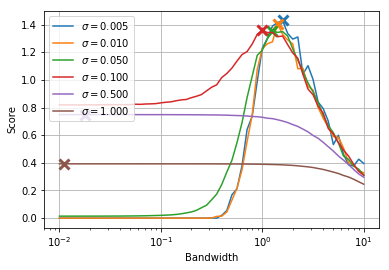

In [24]:
for sigma, e in zip(Sigma, E):
    plthandle = plt.semilogx(H, e, label='$\sigma = {:.3f}$'.format(sigma))
    plt.plot(H[np.argmax(e)], np.max(e), 'x', color=plthandle[0].get_color(), ms=10, mew=3)
plt.grid('on')
plt.xlabel('Bandwidth')
plt.ylabel('Score')
plt.legend(loc='upper left')
tikz('simple_case_scores')

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


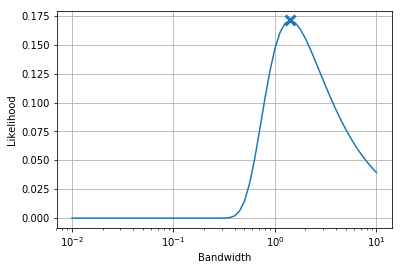

In [25]:
# Compare with maximum likelihood method
x = thetatilde(spl_event.fit(t, v3).theta)
Jml = np.zeros_like(H)
for i, h in enumerate(H):
    kde = KDE(coef_train, bandwidth=h, scale_data=False)
    kde.compute_kde()
    Jml[i] = np.exp(kde.kde.score_samples(x[np.newaxis, :]))
plthandle = plt.semilogx(H, Jml)
plt.plot(H[np.argmax(Jml)], np.max(Jml), 'x', color=plthandle[0].get_color(), ms=10, mew=3)
plt.grid('on')
plt.xlabel('Bandwidth')
plt.ylabel('Likelihood')
tikz('simple_case_likelihood')

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


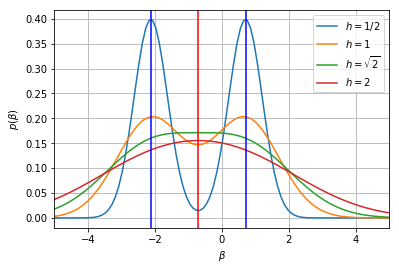

In [26]:
hplot = [0.5, 1, np.sqrt(2), 2]
hlabel = ['$h=1/2$', '$h=1$', '$h=\sqrt{2}$', '$h=2$']
beta = np.linspace(-5, 5, 100)
for h, hl in zip(hplot, hlabel):
    kde = KDE(coef_train, bandwidth=h, scale_data=False)
    kde.compute_kde()
    plt.plot(beta, np.exp(kde.kde.score_samples(beta[:, np.newaxis])), label=hl)
plt.axvline(np.sqrt(2)/2, c='b')
plt.axvline(-3*np.sqrt(2)/2, c='b')
plt.axvline(-np.sqrt(2)/2, c='r')
plt.xlabel('$\\beta$')
plt.ylabel('$p(\\beta)$')
plt.grid('on')
plt.legend()
plt.xlim([np.min(beta), np.max(beta)])
tikz('simple_case_pdf')

## Real example

In [27]:
with open('df.p', 'rb') as f:
    (dfs, scaling) = pickle.load(f)
# Only use first n profiles
n = 400
dfs = dfs[:n].copy()
scaling = scaling.T[:n].copy()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


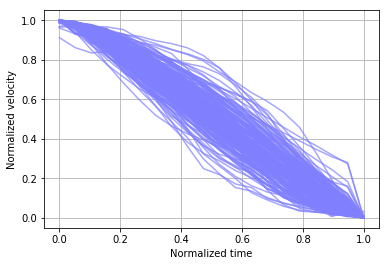

In [28]:
for df in dfs[:200]:
    plt.plot(t, np.interp(t, df['time'], df['vel']), color=[0.5, 0.5, 1], alpha=0.7)
plt.xlabel('Normalized time')
plt.ylabel('Normalized velocity')
plt.grid('on')
tikz('profiles')

In [29]:
# Interpolate all curves
profiles = np.zeros((len(dfs), len(t)))
for i, df in enumerate(dfs):
    profiles[i] = np.interp(t, df['time'], df['vel'])

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


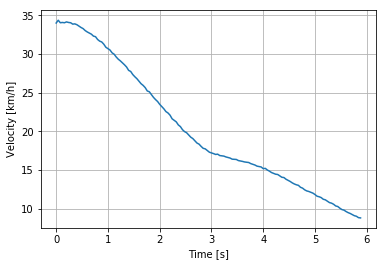

In [30]:
# Show a profile
i = 1
plt.plot(dfs[i]['time']*scaling[i, 0], (dfs[i]['vel']*(scaling[i, 1] - scaling[i, 2]) + scaling[i,2])*3.6)
plt.grid('on')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [km/h]')
tikz('velocity_profile_example')

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


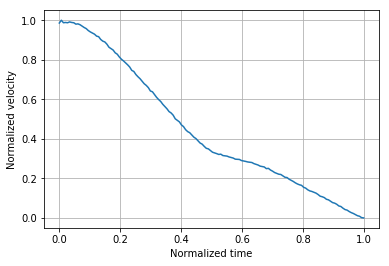

In [31]:
plt.plot(dfs[i]['time'], dfs[i]['vel'])
plt.grid('on')
plt.xlabel('Normalized time')
plt.ylabel('Normalized velocity')
tikz('velocity_profile_example_normalized')

### Influence of number of knots

In [45]:
savefile = os.path.join('pickles', 'test_nknots.p')
sigma = 0.005
N = 10000
NKNOTS = [0, 1, 2, 3, 4]
H = np.logspace(-3, 0, 10)
J = np.zeros((len(NKNOTS), len(H)))
ntest = 10

if overwrite or not os.path.exists(savefile):
    for inknots, nknots in enumerate(tqdm(NKNOTS)):
        print("Number of interior knots: {:d}".format(nknots))
        # Define spline function. Note the +2 because of extra exterior knots
        spl_event = SplineInter1D(np.linspace(0, 1, nknots+2), left_constraints=[1], right_constraints=[0])
        spl = _Spline(spl_event.t, spl_event.d, spl_event.thetafixed)
        spl(t)  # Sets the x-values

        # Compute the spline coefficients
        ncoefs = spl_event.v2.shape[1]
        coefs = np.zeros((len(dfs), ncoefs))
        for i, df in enumerate(dfs):
            coefs[i] = thetatilde(spl_event.fit(df['time'], df['vel']).theta)
        scaler = StandardScaler()
        scaler.fit(coefs)

        # Perform the cross validation
        for ih, h in enumerate(tqdm(H, leave=False)):
            for idf, profile in enumerate(tqdm(profiles[:ntest], leave=False)):
                # Construct the KDE
                kde = KDE(scaler.transform(np.concatenate((coefs[:idf], coefs[idf+1:]))), bandwidth=h, scale_data=False)
                kde.compute_kde()

                # Generate curves and compare
                e = np.zeros(N)
                for i in range(N):
                    z = scaler.inverse_transform(kde.draw_random_sample(1))[0]
                    e[i] = error(profile, z, sigma=sigma)
                #plt.plot(e)

                # Add result to final score
                J[inknots, ih] += np.log(np.mean(e))
                # print(np.mean(e))
                print("\rh = {:.2e}, J = {:.1f}".format(h, J[inknots, ih]/(idf+1)*ntest), end="")
            print("\rh = {:.2e}, J = {:.1f}".format(h, J[inknots, ih]))
            print()
    with open(savefile, 'wb') as f:
        pickle.dump(J, f)
else:
    with open(savefile, 'rb') as f:
        J = pickle.load(f)

Number of interior knots: 0
h = 1.00e-03, J = -92.9

h = 2.15e-03, J = -92.2

h = 4.64e-03, J = -91.9

h = 1.00e-02, J = -91.9

h = 2.15e-02, J = -91.3

h = 4.64e-02, J = -90.0

h = 1.00e-01, J = -89.3

h = 2.15e-01, J = -88.9

h = 4.64e-01, J = -91.7

h = 1.00e+00, J = -96.4

Number of interior knots: 1
h = 1.00e-03, J = -48.3

h = 2.15e-03, J = -48.7

h = 4.64e-03, J = -48.1

h = 1.00e-02, J = -48.0

h = 2.15e-02, J = -48.4

h = 4.64e-02, J = -46.5

h = 1.00e-01, J = -45.2

h = 2.15e-01, J = -43.2

h = 4.64e-01, J = -49.6

h = 1.00e+00, J = -56.0

Number of interior knots: 2
h = 1.00e-03, J = -48.5

h = 2.15e-03, J = -49.3

h = 4.64e-03, J = -48.5

h = 1.00e-02, J = -48.0

h = 2.15e-02, J = -47.6

h = 4.64e-02, J = -44.1

h = 1.00e-01, J = -46.3

h = 2.15e-01, J = -49.2

h = 4.64e-01, J = -64.7

h = 1.00e+00, J = -77.5

Number of interior knots: 3
h = 1.00e-03, J = -46.5

h = 2.15e-03, J = -46.6

h = 4.64e-03, J = -46.7

h = 1.00e-02, J = -47.8

h = 2.15e-02, J = -45.3

h = 4.64e-02,

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


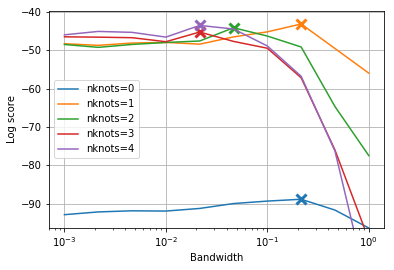

In [48]:
for inknots, nknots in enumerate(NKNOTS):
    plthandle = plt.semilogx(H, J[inknots], label='nknots={:d}'.format(nknots))
    plt.plot(H[np.argmax(J[inknots])], np.max(J[inknots]), 'x', color=plthandle[0].get_color(), ms=10, mew=3)
plt.grid('on')
plt.xlabel('Bandwidth')
plt.ylabel('Log score')
plt.legend()
plt.ylim([np.min(J[0]), plt.ylim()[1]])
tikz('score_nknots')

### Influence of number of coefficients with SVD

In [ ]:
savefile = os.path.join('pickles', 'test_svd.p')
NKNOTS2 = [2, 3, 4]
H2 = np.logspace(-2, 1, 10)

if overwrite or not os.path.exists(savefile):
    JJ = []
    # Loop through all number of knots
    for inknots, nknots in enumerate(tqdm(NKNOTS2)):
        print("Number of interior knots: {:d}".format(nknots))
        # Define spline function. Note the +2 because of extra exterior knots
        spl_event = SplineInter1D(np.linspace(0, 1, nknots+2), left_constraints=[1], right_constraints=[0])
        spl = _Spline(spl_event.t, spl_event.d, spl_event.thetafixed)
        spl(t)  # Sets the x-values

        # Compute the spline coefficients
        ncoefs = spl_event.v2.shape[1]
        coefs = np.zeros((len(dfs), ncoefs))
        for i, df in enumerate(dfs):
            coefs[i] = thetatilde(spl_event.fit(df['time'], df['vel']).theta)
        scaler = StandardScaler()
        scaler.fit(coefs)

        # Perform SVD
        mu = np.mean(coefs, axis=0)
        u, s, v = np.linalg.svd(coefs-mu, full_matrices=False)

        # Initialize result matrix
        jj = np.zeros((ncoefs, len(H)))

        # Try all different amount of coefficients
        for incoef, ncoef in enumerate(tqdm(range(1, ncoefs+1), leave=False)):
            print("Number of coefficients: {:d}".format(ncoef))
            # Define the scaler
            scaler = StandardScaler()
            scaler.fit(u[:, :ncoef])
            # Perform the cross validation
            for ih, h in enumerate(tqdm(H2, leave=False)):
                for idf, profile in enumerate(tqdm(profiles[:ntest], leave=False)):
                    # Construct the KDE
                    kde = KDE(scaler.transform(np.concatenate((u[:idf, :ncoef], u[idf+1:, :ncoef]))), 
                              bandwidth=h, scale_data=False)
                    kde.compute_kde()

                    # Generate curves and compare
                    e = np.zeros(N)
                    for i in range(N):
                        z = scaler.inverse_transform(kde.draw_random_sample(1))[0]
                        e[i] = error(profile, mu + np.dot(z*s[:ncoef], v[:ncoef]), sigma=sigma)
                    #plt.plot(e)

                    # Add result to final score
                    jj[incoef, ih] += np.log(np.mean(e))
                    print("\rh = {:.2e}, J = {:.1f}".format(h, jj[incoef, ih]/(idf+1)*ntest), end="")
                print("\rh = {:.2e}, J = {:.1f}".format(h, jj[incoef, ih]))
                print()
        JJ.append(jj)
    with open(savefile, 'wb') as f:
        pickle.dump(JJ, f)
else:
    with open(savefile, 'rb') as f:
        JJ = pickle.load(f)

Number of interior knots: 2
Number of coefficients: 1
h = 1.00e-02, J = -592.2

h = 2.15e-02, J = -592.0

h = 4.64e-02, J = -805.5

In [ ]:
f, axs = plt.subplots(1, len(JJ), figsize=(5*len(JJ), 4))
for ax, jj, nknots in zip(axs, JJ, NKNOTS2):
    for incoef, ncoef in enumerate(range(1, len(jj)+1)):
        plthandle = ax.semilogx(H2, jj[incoef], label='ncoef={:d}'.format(ncoef))
        ax.plot(H2[np.argmax(jj[incoef])], np.max(jj[incoef]), 'x', color=plthandle[0].get_color(), ms=10, mew=3)
    ax.grid('on')
    ax.set_xlabel('Bandwidth')
    ax.set_ylabel('Score')
    ax.set_title('Number of interior knots: {:d}'.format(nknots))
    ax.legend()
plt.tight_layout()

In [ ]:
f, axs = plt.subplots(1, len(JJ), figsize=(5*len(JJ), 4))
for ax, j, jj, nknots in zip(axs, [J[i] for i in np.searchsorted(NKNOTS, NKNOTS2)], JJ, NKNOTS2):
    plthandle = ax.semilogx(H, j, label='orig')
    ax.plot(H[np.argmax(j)], np.max(j), 'x', color=plthandle[0].get_color(), ms=10, mew=3)
    plthandle = ax.semilogx(H2, jj[-1], label='svd'.format(ncoef))
    ax.plot(H2[np.argmax(jj[-1])], np.max(jj[-1]), 'x', color=plthandle[0].get_color(), ms=10, mew=3)
    ax.grid('on')
    ax.set_xlabel('Bandwidth')
    ax.set_ylabel('Score')
    ax.set_title('Number of interior knots: {:d}'.format(nknots))
    ax.legend()
plt.tight_layout()

In [ ]:
knots = 2
Jorig = [J[i] for i in np.searchsorted(NKNOTS, NKNOTS2)]
i = np.searchsorted(NKNOTS2, knots)
plthandle = plt.semilogx(H, Jorig[i], label='orig, max={:.1f}'.format(np.max(Jorig[i])))
plt.plot(H[np.argmax(Jorig[i])], np.max(Jorig[i]), 'x', color=plthandle[0].get_color(), ms=10, mew=3)
plthandle = plt.semilogx(H2, JJ[i][-1], label='svd, max={:.1f}'.format(np.max(JJ[i][-1])))
plt.plot(H2[np.argmax(JJ[i][-1])], np.max(JJ[i][-1]), 'x', color=plthandle[0].get_color(), ms=10, mew=3)
plt.xlabel('Bandwidth')
plt.ylabel('Score')
plt.title('Number of interior knots: {:d}'.format(knots))
plt.legend()
plt.grid('on')
plt.ylim([np.min(Jorig[i]), plt.ylim()[1]])
tikz('svd{:d}'.format(knots))

### Copulas

In [ ]:
nknots = 0

spl_event = SplineInter1D(np.linspace(0, 1, nknots+2), left_constraints=[1], right_constraints=[0])
spl = _Spline(spl_event.t, spl_event.d, spl_event.thetafixed)
spl(t)  # Sets the x-values

# Compute the spline coefficients
ncoefs = spl_event.v2.shape[1]
coefs = np.zeros((len(dfs), ncoefs))
for i, df in enumerate(dfs):
    coefs[i] = thetatilde(spl_event.fit(df['time'], df['vel']).theta)
scaler = StandardScaler()
scaler.fit(coefs)

In [ ]:
# For comparison, compute score when very small bandwidth is used
J = 0
J2 = 0
kde = KDE(data=scaler.transform(coefs), scale_data=False, bandwidth=1e-6)
for idf, profile in enumerate(tqdm(profiles[:ntest], leave=True)):
    #kde = KDE(data=scaler.transform(np.concatenate((coefs[:idf], coefs[idf+1:]))), scale_data=False, bandwidth=1e-6)
    kde.compute_kde()
    e = np.zeros(N)
    for i in range(N):
        X = kde.draw_random_sample(1)[0]
        z = scaler.inverse_transform(X)
        J2 += np.min(np.sum((coefs - z)**2, axis=1))
        e[i] = error(profile, z, sigma=sigma)
    J += np.log(np.mean(e))
print(J)
print(J2)

In [ ]:
scoefs = scaler.transform(coefs)
normcoefs = np.zeros_like(scoefs)  # Normalized coefficients, such that marginals are uniform distributions
x = np.linspace(-5, 5, 10001)
cdf = np.zeros((len(x), ncoefs))
h = 0.001
for i in range(scoefs.shape[1]):
    kde = KDE(data=scoefs[:, i:i+1], scale_data=False, bandwidth=h)
    kde.compute_kde()
    y = np.exp(kde.kde.score_samples(x[:, np.newaxis]))
    cdf[:, i] = np.cumsum(y * np.gradient(x))
    cdf[:, i] /= cdf[-1, i]
    normcoefs[:, i] = np.interp(scoefs[:, i], x, cdf[:, i])

In [ ]:
H = np.logspace(-5, -1, 5)

J = np.zeros_like(H)
J2 = 0
for ih, h in enumerate(tqdm(H)):
    kde = KDE(data=normcoefs, scale_data=False, bandwidth=h)
    kde.compute_kde()
    for idf, profile in enumerate(tqdm(profiles[:ntest], leave=False)):
        e = np.zeros(N)
        for i in range(N):
            X = kde.draw_random_sample(1)[0]
            X = np.min([np.mod(X, 2), 2-np.mod(X, 2)], axis=0)
            #while np.any(X <= 0) or np.any(X >= 1):
            #    X = kde.draw_random_sample(1)[0]
            Xscaled = [np.interp(X[i], cdf[:, i], x) for i in range(ncoefs)]
            z = scaler.inverse_transform(Xscaled)
            J2 += np.min(np.sum((coefs - z)**2, axis=1))
            e[i] = error(profile, z, sigma=sigma)
        J[ih] += np.log(np.mean(e))
        print("\rh = {:.2e}, J = {:.1f}".format(h, J[ih]/(idf+1)*ntest), end="")
    print("\rh = {:.2e}, J = {:.1f}".format(h, J[ih]))
    print()

In [ ]:
J2

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
for i in range(ncoefs):
    ax1.plot(x, cdf[:, i])
    ax2.plot(x, np.gradient(cdf[:, i])/np.gradient(x))

In [ ]:
# Show copula density
kde = KDE(data=normcoefs, scale_data=False, bandwidth=0.001)
kde.compute_kde()
n = 50
q = np.linspace(0, 1, n)
if ncoefs == 2:
    qq, rr = [x.ravel() for x in np.meshgrid(q, q)]
    scores = np.zeros((n, n))
    for q in tqdm([-qq, qq, 2-qq]):
        for r in tqdm([-rr, rr, 2-rr], leave=False):
            pp = np.array([q, r]).T
            scores += np.reshape(np.exp(kde.kde.score_samples(pp)), (n, n))
    #scores = np.reshape(np.exp(kde.kde.score_samples(np.array([qq, rr]).T)), (n, n))
    plt.imshow(scores)
    
elif ncoefs == 3:
    qq, rr, ss = [x.ravel() for x in np.meshgrid(q, q, q)]
    scores = np.zeros((n, n, n))
    for q in tqdm([-qq, qq, 2-qq]):
        for r in tqdm([-rr, rr, 2-rr], leave=False):
            for s in tqdm([-ss, ss, 2-ss], leave=False):
                pp = np.array([q, r, s]).T
                scores += np.reshape(np.exp(kde.kde.score_samples(pp)), (n, n, n))

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(0, n-1), ylim=(0, n-1))
    im = ax.imshow(scores[0])

    # initialization function: plot the background of each frame
    def init():
        im.set_data(scores[0])
        return (im,)

    # animation function.  This is called sequentially
    def animate(i):
        im.set_data(scores[i])
        return (im,)

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=n, interval=50, blit=True)

    # call our new function to display the animation
    HTML(anim.to_html5_video())

In [ ]:
np.meshgrid((q, q))[0].shape

In [ ]:
x = np.meshgrid(*(q for _ in range(2)))